In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [3]:
model_path = "P_magnitude_models_evid_C0.5_e0.1"
train_evids = np.loadtxt(f"{model_path}/train_evids.txt")
test_evids = np.loadtxt(f"{model_path}/test_evids.txt")
test_summary_df = pd.read_csv(f"{model_path}/combined_test_summary_df.csv")
assert test_summary_df.event_identifier.unique().shape == test_evids.shape

In [4]:
test_summary_df[test_summary_df["event_identifier"] == test_evids[0]]

,event_identifier,location_code,magnitude,magnitude_type,network,station,predicted_magnitude
662,60332172,1,1.67,l,WY,YNR,1.580764
1556,60332172,1,1.67,l,WY,YHH,1.499975
2302,60332172,1,1.67,l,WY,YMC,1.526712
3715,60332172,1,1.67,l,WY,YPM,1.646543
4437,60332172,1,1.67,l,WY,YWB,1.636288
5158,60332172,1,1.67,l,WY,MCID,1.649070
5833,60332172,1,1.67,l,WY,YHB,1.581567
6405,60332172,1,1.67,l,WY,YFT,1.450476
7046,60332172,1,1.67,l,WY,YHL,1.607686
8235,60332172,1,1.67,l,WY,YDC,1.502139


In [5]:
test_summary_df[test_summary_df["event_identifier"] == test_evids[0]].predicted_magnitude.mean()

1.5656614457018743

In [6]:
network_avg_df = pd.merge(test_summary_df.groupby("event_identifier").predicted_magnitude.mean().reset_index(), 
         test_summary_df[["event_identifier", "magnitude"]].drop_duplicates(), how="inner")

In [7]:
network_avg_df[network_avg_df["event_identifier"] == 60332172]

,event_identifier,predicted_magnitude,magnitude
837,60332172,1.565661,1.67


0.8970785650438962


Text(0, 0.5, 'Predicted Network Magnitude')

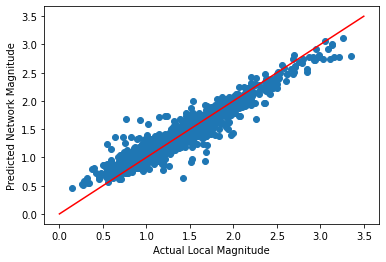

In [8]:
plt.scatter(network_avg_df["magnitude"], network_avg_df["predicted_magnitude"])
plt.plot(np.arange(0, 4, 0.5), np.arange(0, 4, 0.5), color="red")
# r2_score(y_true, y_pred)
network_avg_r2 = r2_score(network_avg_df["magnitude"], network_avg_df["predicted_magnitude"])
print(network_avg_r2)
plt.xlabel("Actual Local Magnitude")
plt.ylabel("Predicted Network Magnitude")

In [9]:
results_df = pd.read_csv(f"{model_path}/stat_results_df.csv")
results_df = results_df.drop('Unnamed: 0', axis=1)
results_df.columns = ['station', 'test_mse', 'test_r2', 'train_mse', 'train_r2',
       'ngb_mse', 'ngb_r2', 'train_count', 'test_count', 'ngb_count']
results_df.head()

,station,test_mse,test_r2,train_mse,train_r2,ngb_mse,ngb_r2,train_count,test_count,ngb_count
0,YNR,0.043295,0.850833,0.038196,0.876987,0.073496,0.747364,3621.0,884.0,512.0
1,YHH,0.046140,0.842535,0.036066,0.882698,0.075052,0.737279,3496.0,855.0,656.0
2,YMC,0.060787,0.796495,0.057751,0.821250,0.170120,0.419475,3209.0,783.0,459.0
3,YMR,0.045993,0.835680,0.041027,0.867598,0.047036,0.824997,2881.0,690.0,667.0
4,YPM,0.040884,0.856372,0.035298,0.889907,0.048075,0.824999,2904.0,701.0,596.0


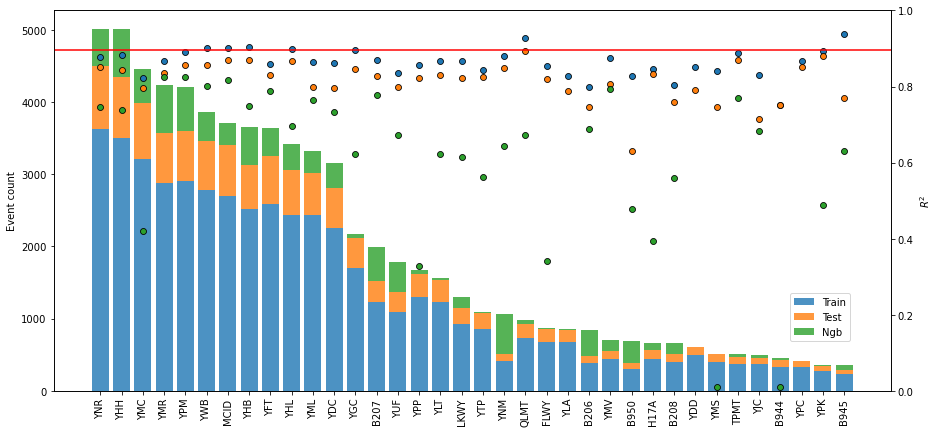

In [10]:
from collections import OrderedDict
fig = plt.figure(1, figsize=(15, 7))

x_range = range(0, len(results_df))

plt.bar(x_range, results_df.train_count, label="Train", alpha=0.8)
plt.bar(x_range, results_df.test_count, bottom=results_df.train_count, label="Test", alpha=0.8)
plt.bar(x_range, results_df.ngb_count, bottom=results_df.train_count+results_df.test_count, label="Ngb", alpha=0.8)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc=(0.88, 0.13))

ax1 = plt.gca()
ax1.set_xticks(x_range, labels=results_df["station"], rotation="vertical");
ax2 = ax1.twinx()

plt.scatter(x_range, results_df.train_r2, label="train", marker="o", color="C0", edgecolor="k", linewidth=0.8)
plt.scatter(x_range, results_df.test_r2, label="test", marker="o", color="C1", edgecolor="k", linewidth=0.8)

ngb_r2 = results_df["ngb_r2"].copy()
ngb_r2[ngb_r2 < 0] = 0.01

plt.scatter(x_range, ngb_r2, label="ngb", marker="o", color="C2", edgecolor="k", linewidth=0.8)

ax1.set_ylabel("Event count")
ax2.set_ylabel(r"$R^2$")
ax2.set_ylim([0, 1.0])

ax2.axhline(network_avg_r2, color="red", label="Test Network Average")
# ax2.legend()

# Make weights for average

In [11]:
# train_features_df = pd.read_csv('p_features.csv', dtype={'location_code': str})
# train_features_df = train_features_df[np.isin(train_features_df.event_identifier, train_evids)]
# stat_counts = pd.read_csv("feature_station_counts.csv")
# train_features_df = train_features_df[np.isin(train_features_df.station, stat_counts[stat_counts.Count >= 350])]
# train_features_df = train_features_df[['event_identifier', 'location_code', 'magnitude', 'magnitude_type', 
#                                        'network', 'station', "avg_signal_1.00", "avg_noise_1.00", "avg_signal_18.00", 
#                                        "signal_variance","source_receiver_distance_km", "source_depth_km", 
#                                        "source_receiver_back_azimuth"]]
# train_features_df.loc[:, "amp_ratio_01.0"] = np.log(train_features_df['avg_signal_1.00']) - np.log(train_features_df['avg_noise_1.00'])
# train_features_df.loc[:, "amp_01.0"] = np.log(train_features_df['avg_signal_1.00']) 
# train_features_df.loc[:, "amp_18.0"] = np.log(train_features_df['avg_signal_18.00']) 
# train_features_df.loc[:, "log_signal_variance"] = np.log(train_features_df['signal_variance']) 
# train_features_df.loc[:, "source_receiver_distance_logkm"] = np.log(train_features_df['source_receiver_distance_km']) 

# # # These are effectively amplitude ratios.  Note,
# # # log(a/b) = log(a) - log(b)
# # X[:,0]  = np.log(df['avg_signal_1.00']) - np.log(df['avg_noise_1.00'])
# # # Look at amplitudes
# # X[:,1] = np.log(df['avg_signal_1.00']) 
# # X[:,2] = np.log(df['avg_signal_18.00'])
# # # Time-based featuers: Look at max amplitudes of noise/signal
# # X[:,3] = np.log(df['signal_variance'])
# # # Source/recv distance (take log to flatten this)
# # X[:,4] = np.log(df['source_receiver_distance_km'])
# # X[:,5] = df['source_depth_km']
# # # Single stations can learn location
# # X[:,6] = df['source_receiver_back_azimuth']

## Remove predictions that the magnitude is out of their min/max range

In [13]:
train_mag_dists = {}
for stat in results_df.station:
    stat_df = pd.read_csv(f"{model_path}/{stat}_train_summary_df.csv")
    quantiles = np.quantile(stat_df.magnitude, [0.25, 0.5, 0.75])
    feat_min = np.min(stat_df.magnitude)
    feat_max = np.max(stat_df.magnitude)
        
    train_mag_dists[stat] = {"Q1": quantiles[0], "Q2": quantiles[1], "Q3":quantiles[2],
                        "min":feat_min, "max":feat_max}

In [65]:
new_magnitude_df = []
for test_evid in test_summary_df.event_identifier.unique():
    test_evid_df = test_summary_df[test_summary_df.event_identifier == test_evid].copy()
    largest_diff = 0
    while largest_diff > -1:
        network_mag = np.mean(test_evid_df.predicted_magnitude)
        largest_diff = -1
        stat_index_to_remove = None
        for i, stat_row in test_evid_df.iterrows():
            stat = stat_row.station
            stat_max = train_mag_dists[stat]["max"]
            stat_min = train_mag_dists[stat]["min"]
            diff = -1
            if network_mag < stat_min:
                diff = abs(network_mag-stat_min)
            elif network_mag > stat_max:
                diff = abs(network_mag-stat_min)

            if diff > largest_diff:
                print("Updating")
                largest_diff = diff
                stat_index_to_remove = stat_row.name

        if stat_to_remove is not None:
            print("Removing index", stat_index_to_remove)
            test_evid_df.drop(index=stat_index_to_remove, axis=1)

    new_magnitude_df.append(test_evid_df)

In [54]:
new_magnitude_df = pd.concat(new_magnitude_df)

In [56]:
new_network_avg_df = pd.merge(new_magnitude_df.groupby("event_identifier").predicted_magnitude.mean().reset_index(), 
         test_summary_df[["event_identifier", "magnitude"]].drop_duplicates(), how="inner")

In [59]:
new_magnitude_df.shape

(12228, 7)

In [60]:
test_summary_df.shape

(12228, 7)

In [41]:
new_magnitude_df = []
while largest_diff > -1:
    network_mag = np.mean(test_evid_df.predicted_magnitude)
    largest_diff = -1
    stat_index_to_remove = None
    for i, stat_row in test_evid_df.iterrows():
        stat = stat_row.station
        stat_max = train_mag_dists[stat]["max"]
        stat_min = train_mag_dists[stat]["min"]
        diff = -1
        if network_mag < stat_min:
            diff = abs(network_mag-stat_min)
        elif network_mag > stat_max:
            diff = abs(network_mag-stat_min)

        if diff > largest_diff:
            largest_diff = diff
            stat_index_to_remove = stat_row.name
    
    if stat_to_remove is not None:
        print("Removing index", stat_index_to_remove)
        test_evid_df.drop(index=stat_index_to_remove, axis=1)
        
new_magnitude_df.append(test_evid_df)

## Weight ideas:
1. Feature quanitiles - where does the feature value exist in the distribution of the training features? If outside the min/max = 0, if between fence and min/max = 0.25, if between the fence and Q1/Q3 = 0.75, if between Q1 & Q3 = 1.0. 
2. Predicted magnitude location in training magnitude distribution. If prediction is greater than the fence, weight to ?.
3. Average of other station magnitude prediction in station training magnitude distribution. If greater than fence, weight to ?. 
4. Train and/or test R2 or MSE. Scaled or raw? Weighted by number of examples in data set?
5. Number of examples in training set - scaled or binned?

In [118]:
selected_features = ['source_receiver_distance_logkm', "source_receiver_back_azimuth", "amp_18.0",
                     "amp_01.0", "amp_ratio_01.0", "log_signal_variance", "source_depth_km", "magnitude"]
train_feature_dists = {}
for stat in results_df.station:
    stat_df = pd.read_csv(f"{model_path}/{stat}_train_summary_df.csv")
    stat_feats = {}
    for feat in selected_features:
        stat_feat_vals = stat_df[feat]
        quantiles = np.quantile(stat_feat_vals, [0.25, 0.5, 0.75])
        feat_min = np.min(stat_feat_vals)
        feat_max = np.max(stat_feat_vals)
        stat_feats[feat] = {"Q1": quantiles[0], "Q2": quantiles[1], "Q3":quantiles[2],
                            "min":feat_min, "max":feat_max}
        
    train_feature_dists[stat] = stat_feats

In [119]:
train_feature_dists

{'YNR': {'source_receiver_distance_logkm': {'Q1': -0.5108653406439716,
   'Q2': 0.3521978413997751,
   'Q3': 0.6154482770509161,
   'min': -9.663119744829563,
   'max': 2.343474186508205},
  'source_receiver_back_azimuth': {'Q1': -0.5174278619248059,
   'Q2': 0.5427334934782221,
   'Q3': 0.6520486027498494,
   'min': -3.446715500567997,
   'max': 1.677710612069218},
  'amp_18.0': {'Q1': -0.7099632864148149,
   'Q2': -0.1136013296459725,
   'Q3': 0.64163897970456,
   'min': -2.6180715525959584,
   'max': 4.549529771542694},
  'amp_01.0': {'Q1': -0.7146511734808679,
   'Q2': -0.1450578556207559,
   'Q3': 0.5971771656090412,
   'min': -2.5504536742461577,
   'max': 5.8451643981061405},
  'amp_ratio_01.0': {'Q1': -0.7557602785205477,
   'Q2': 0.017461646865536,
   'Q3': 0.6889769438500855,
   'min': -2.1302148030433634,
   'max': 3.5226569191242776},
  'log_signal_variance': {'Q1': -0.737940932880537,
   'Q2': -0.1394961889076696,
   'Q3': 0.6370714836307168,
   'min': -2.171923260724042,


In [294]:
def get_feature_weight(feat_val, feat_dist):
    Q1 = feat_dist["Q1"]
    Q3 = feat_dist["Q3"]
    iqr =  Q3 - Q1
    lower_fence = Q1 - 1.5*iqr
    upper_fence = Q3 + 1.5*iqr
    if feat_val < feat_dist["min"] or feat_val > feat_dist["max"]:
        weight = 0.0
    elif feat_val < lower_fence or feat_val > upper_fence:
        weight = 0.5
    elif feat_val < Q1 or feat_val > Q3:
        weight = 1.0
    else:
        weight = 2.0
        
    return weight

In [268]:
count_dists = {}
for cnt_type in ["train_count", "test_count"]:
    dist = {}
    quantiles = np.quantile(results_df[cnt_type], [0.25, 0.5, 0.75])
    dist["Q1"] = quantiles[0]
    dist["Q2"] = quantiles[1]
    dist["Q3"] = quantiles[2]
    count_dists[cnt_type] = dist

In [269]:
count_dists

{'train_count': {'Q1': 406.75, 'Q2': 892.5, 'Q3': 2458.25},
 'test_count': {'Q1': 106.0, 'Q2': 225.5, 'Q3': 616.25}}

In [270]:
def get_count_weight(count, count_dist):
    if count < count_dist["Q1"]:
        weight = 0.75
    elif count < count_dist["Q2"]:
        weight = 0.85
    elif count < count_dist["Q3"]:
        weight = 0.95
    else:
        weight = 1.0
    
    return weight

In [295]:
example_weights = []
station_weights  = {} 
for stat in list(train_feature_dists.keys()):
    stat_result_df = results_df[results_df["station"] == stat]
    
    train_cnt_weight = get_count_weight(stat_result_df["train_count"].values, count_dists["train_count"])
    test_cnt_weight = get_count_weight(stat_result_df["test_count"].values, count_dists["test_count"])
    
    train_r2 = stat_result_df.train_r2.values[0]
    test_r2 = stat_result_df.test_r2.values[0]
    
    station_weights[stat] = {"train_count":train_cnt_weight, "test_count":test_cnt_weight, 
                             "train_r2":train_r2, "test_r2":test_r2}
    
    stat_feat_dists = train_feature_dists[stat]
    stat_test_summary_df = pd.read_csv(f"{model_path}/{stat}_test_summary_df.csv")
    stat_feature_weights = {"evid":stat_test_summary_df.evid.values, "station":np.full(len(stat_test_summary_df), stat)}
    for feature in selected_features[:-1]:
        stat_feature_weights[feature] = stat_test_summary_df.apply(lambda x: get_feature_weight(x[feature], 
                                                                train_feature_dists[stat][feature]), axis=1).values
    stat_weights_df = pd.DataFrame(stat_feature_weights)
    stat_weights_df.loc[:, "mean_weight"] = stat_weights_df[stat_weights_df.columns[2:]].mean(axis=1)
    example_weights.append(stat_weights_df)
example_weights_df = pd.concat(example_weights)
station_weights_df = pd.DataFrame(station_weights).transpose()

In [296]:
station_weights_df

,train_count,test_count,train_r2,test_r2
YNR,1.00,1.00,0.876987,0.850833
YHH,1.00,1.00,0.882698,0.842535
YMC,1.00,1.00,0.821250,0.796495
YMR,1.00,1.00,0.867598,0.835680
YPM,1.00,1.00,0.889907,0.856372
YWB,1.00,1.00,0.900620,0.855806
MCID,1.00,1.00,0.901653,0.869316
YHB,1.00,1.00,0.903544,0.870004
YFT,1.00,1.00,0.857901,0.829341
YHL,0.95,0.95,0.898613,0.867592


In [273]:
example_weights_df[example_weights_df.columns[2:-1]].prod(axis=1).describe()

count    12228.000000
mean         2.855880
std          3.572157
min          0.000000
25%          0.533936
50%          1.067871
75%          4.271484
max         17.085938
dtype: float64

In [274]:
example_weights_df.mean_weight.describe()

count    12228.000000
mean         1.119649
std          0.188591
min          0.571429
25%          0.964286
50%          1.071429
75%          1.285714
max          1.500000
Name: mean_weight, dtype: float64

In [297]:
weighted_test_df = test_summary_df.copy()
weights = []
for i, row in weighted_test_df.iterrows():
    stat = row['station']
    evid = row["event_identifier"]
    feature_weight = example_weights_df[(example_weights_df.station == stat) & 
                                          (example_weights_df.evid == evid)].mean_weight.values[0]
    stat_weight = station_weights_df[station_weights_df.index == stat].mean(axis=1).values[0]
    combined_weight = np.mean([feature_weight, stat_weight])
    weights.append({"station":stat, "event_identifier":evid, "stat_weight":stat_weight, "feature_weight":feature_weight, 
                   "combined_weight":combined_weight})
    
# for evid in test_summary_df.event_identifier.unique():
#     evid_df = test_summary_df[test_summary_df.event_identifier == evid]
#     evid_feature_weights = example_weights_df[example_weights_df.evid == evid]
#     for i, row in evid_df.iterrows():
#         stat = row["station"]
#         feature_weight = evid_feature_weights[evid_feature_weights.station == stat].mean_weight.values[0]
        
#         weights.append({"evid":evid, ""})
#         print(feature_weight, stat_weight, np.mean([feature_weight, stat_weight]), feature_weight*stat_weight)
#     print(evid)
#     break

In [299]:
all_weights_df = pd.DataFrame(weights)

In [300]:
weighted_test_df = pd.merge(weighted_test_df, all_weights_df, on=["station", "event_identifier"])

In [301]:
weighted_test_df

,event_identifier,location_code,magnitude,magnitude_type,network,station,predicted_magnitude,stat_weight,feature_weight,combined_weight
0,60001372,1,2.52,l,WY,YNR,2.298452,0.931955,1.428571,1.180263
1,60001382,1,3.16,l,WY,YNR,2.669727,0.931955,1.214286,1.073120
2,60002142,1,2.50,l,WY,YNR,2.603285,0.931955,1.285714,1.108835
3,60003742,1,0.97,l,WY,YNR,1.220619,0.931955,1.428571,1.180263
4,60004627,1,1.43,l,WY,YNR,1.397648,0.931955,1.142857,1.037406
...,...,...,...,...,...,...,...,...,...,...
12223,60046777,1,1.99,l,PB,B945,1.801328,0.802056,1.714286,1.258171
12224,60046967,1,1.19,l,PB,B945,1.085658,0.802056,1.428571,1.115314
12225,60047112,1,1.14,l,PB,B945,1.000007,0.802056,1.142857,0.972457
12226,60047902,1,1.01,l,PB,B945,1.478150,0.802056,1.642857,1.222457


In [302]:
weighted_network_avg_df = pd.merge(network_avg_df, weighted_test_df.groupby("event_identifier").apply(lambda x: np.average(x.predicted_magnitude, 
                                                                        weights=x.combined_weight)).reset_index())

In [303]:
weighted_network_avg_df = pd.merge(network_avg_df, weighted_test_df.groupby("event_identifier").apply(lambda x: np.average(x.predicted_magnitude, 
                                                                        weights=x.feature_weight)).reset_index())

In [304]:
r2_score(weighted_network_avg_df.magnitude, weighted_network_avg_df[0]) 

0.8967601095878552

In [287]:
weighted_network_avg_df

,event_identifier,predicted_magnitude,magnitude,0
0,60001357,2.003166,1.97,2.004718
1,60001372,2.410712,2.52,2.412391
2,60001382,2.778017,3.16,2.784256
3,60001412,2.139702,2.24,2.138709
4,60001432,1.909006,1.70,1.899375
...,...,...,...,...
1142,60469787,1.126227,1.33,1.125363
1143,60469912,1.039536,1.04,1.039820
1144,60470442,1.750756,1.92,1.749066
1145,60471327,1.402398,1.79,1.424750


In [285]:
weighted_test_df[weighted_test_df.event_identifier == 60473522]

,event_identifier,location_code,magnitude,magnitude_type,network,station,predicted_magnitude,stat_weight,feature_weight,combined_weight
3211,60473522,1,2.46,l,WY,YMR,2.372820,0.925820,1.035714,0.980767
5293,60473522,1,2.46,l,WY,MCID,2.234585,0.942742,0.821429,0.882085
6570,60473522,1,2.46,l,WY,YFT,2.276489,0.921810,1.071429,0.996620
7768,60473522,1,2.46,l,WY,YML,2.167399,0.890606,0.964286,0.927446
9297,60473522,1,2.46,l,WY,YUF,1.975005,0.883756,0.642857,0.763307
9450,60473522,1,2.46,l,WY,YPP,2.614633,0.894907,1.071429,0.983168
9912,60473522,1,2.46,l,WY,YLT,2.305790,0.899862,1.178571,1.039217
10363,60473522,1,2.46,l,WY,YTP,2.180708,0.842024,0.964286,0.903155
10831,60473522,0,2.46,l,IW,FLWY,2.473529,0.843421,0.892857,0.868139
11005,60473522,1,2.46,l,WY,YLA,2.042231,0.828997,1.178571,1.003784
